In [1]:
macro space(name::Symbol, ex::Expr, methods::Expr...)
    Meta.isexpr(ex, :block) || throw(ArgumentError("@space expects a begin...end block"))
    decls = filter(e -> !(e isa LineNumberNode), ex.args)
    all(e -> Meta.isexpr(e, :(::)), decls) || throw(ArgumentError("@space must contain a sequence of name::type expressions"))
    
    # Prepare vars and types for struct definition
    vars_types = [(e isa Symbol ? e : e.args[1], e isa Symbol ? :Any : e.args[2]) for e in decls]

    # Construct the struct definition directly without string manipulation
    struct_expr = Expr(:struct, true, name, Expr(:block, [Expr(:(::), var, type) for (var, type) in vars_types]...))
    
    # Evaluate the struct definition
    eval(struct_expr)

    # Generate methods
    # i am not really sure how to use this, but what i want is to be able to equip a space with a standard "package of methods"
    # the examples below are demonstrative -- Cartesian is prett standard but Polar is an example of more space-specific methods
    for method in methods
        method_name = method.args[1].args[1]
        method_args = method.args[1].args[2:end]
        method_body = method.args[2]
        method_expr = Expr(:function, Expr(:call, method_name, name, method_args...), method_body)
        eval(method_expr)
    end
end

@space (macro with 1 method)

In [2]:
@space CartesianCoords begin
    x::Real
    y::Real
end

In [3]:
import Base: +, -, *, /, ==, <, <=, >, >=

function +(a::CartesianCoords, b::CartesianCoords)::CartesianCoords
    return CartesianCoords(a.x + b.x, a.y + b.y)
end

function -(a::CartesianCoords, b::CartesianCoords)::CartesianCoords
    return CartesianCoords(a.x - b.x, a.y - b.y)
end

function *(scalar::Real, coords::CartesianCoords)::CartesianCoords
    return CartesianCoords(scalar * coords.x, scalar * coords.y)
end

#include the reverse order of scalar multiplication
function *(coords::CartesianCoords, scalar::Real)::CartesianCoords
    return CartesianCoords(scalar * coords.x, scalar * coords.y)
end

function /(coords::CartesianCoords, scalar::Real)::CartesianCoords
    return CartesianCoords(coords.x / scalar, coords.y / scalar)
end

function dot(a::CartesianCoords, b::CartesianCoords)::Real
    return a.x * b.x + a.y * b.y
end

function ==(a::CartesianCoords, b::CartesianCoords)::Bool
    return a.x == b.x && a.y == b.y
end

function magnitude(coords::CartesianCoords)::Real
    return sqrt(coords.x^2 + coords.y^2)
end

function >(a::CartesianCoords, b::CartesianCoords)::Bool
    return magnitude(a) > magnitude(b)
end

function <(a::CartesianCoords, b::CartesianCoords)::Bool
    return magnitude(a) < magnitude(b)
end

function >=(a::CartesianCoords, b::CartesianCoords)::Bool
    return magnitude(a) >= magnitude(b)
end

function <=(a::CartesianCoords, b::CartesianCoords)::Bool
    return magnitude(a) <= magnitude(b)
end

<= (generic function with 56 methods)

In [4]:
point1 = CartesianCoords(-3.0, 4.0)
point2 = CartesianCoords(1.0, 2.0)

result = point1 + point2
println(result)  # Output: CartesianCoords(-2.0, 6.0)

CartesianCoords(-2.0, 6.0)


In [5]:
@space PolarCoords begin
    angle::Real
    radius::Real
end

function normalize(obj::PolarCoords)::PolarCoords
    new_radius = abs(obj.radius)
    new_angle = mod(obj.angle + π * (obj.radius < 0), 2π)
    return PolarCoords(new_angle, new_radius)
end

normalize (generic function with 1 method)

In [6]:
pointA = PolarCoords(7π/2, -5.0)
pointAbasic = normalize(pointA)
println(pointAbasic)  # Output: PolarCoords(1.5707963267948966, 5.0)

PolarCoords(1.5707963267948966, 5.0)


In [7]:
function polarToCartesian(polar::PolarCoords)::CartesianCoords
    x = polar.radius * cos(polar.angle)
    y = polar.radius * sin(polar.angle)
    return CartesianCoords(x, y)
end

# Function to convert Cartesian (x, y) back to PolarCoords
function cartesianToPolar(cart::CartesianCoords)::PolarCoords
    x = cart.x
    y = cart.y
    radius = sqrt(x^2 + y^2)
    angle = atan(y, x)
    angle = angle < 0 ? angle + 2π : angle  # Ensure angle is positive
    return PolarCoords(angle, radius)
end

cartesianToPolar (generic function with 1 method)

In [8]:
function +(a::PolarCoords, b::PolarCoords)::PolarCoords
    # Convert both PolarCoords to Cartesian
    carta = polarToCartesian(a)
    ax, ay = carta.x, carta.y
    cartb = polarToCartesian(b)
    bx, by = cartb.x, cartb.y
    
    # Perform addition in Cartesian coordinates
    cx = ax + bx
    cy = ay + by

    res = CartesianCoords(cx, cy)
    
    # Convert the result back to PolarCoords
    return cartesianToPolar(res)
end

function -(a::PolarCoords)::PolarCoords
    return PolarCoords(a.angle + π, a.radius)
    
end

function -(a::PolarCoords, b::PolarCoords)::PolarCoords
    return a + (-b)
end

- (generic function with 214 methods)

In [9]:
polA = PolarCoords(3π/2, 5.0)
polB = PolarCoords(π/2, 3.0)

polA - polB

PolarCoords(4.71238898038469, 8.0)

In [10]:
using Pkg
Pkg.add("Plots")

using Plots

function plotPolarVector(polarCoord::PolarCoords)
    # Extract the angle (in radians) and radius from the PolarCoords
    angle = polarCoord.angle
    radius = polarCoord.radius
    
    # Convert the polar coordinates to Cartesian for plotting
    x = radius * cos(angle)
    y = radius * sin(angle)
    
    # Create a polar plot with the origin and the vector point
    p = plot([0, angle], [0, radius], proj=:polar, m=1, label="Vector", lw=2, arrow=true,
             xlims=(0, 1.5*radius), ylims=(0, 1.5*radius),
             title="Polar Coordinate Vector", xlabel="Angle (radians)", ylabel="Radius")
    
    # Plot the vector point
    scatter!([angle], [radius], label="End Point")
    
    display(p)
end

    Updating registry at `~/.julia/registries/General.toml`
   Resolving package versions...


┌ Warning: julia version requirement for project not satisfied
└ @ nothing nothing:309
  No Changes

 to `~/Documents/GitHub/cadCAD.jl/Project.toml`
  No Changes to `~/Documents/GitHub/cadCAD.jl/Manifest.toml`


plotPolarVector (generic function with 1 method)

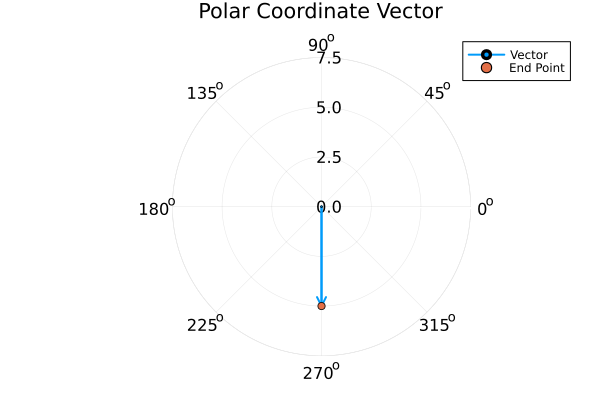

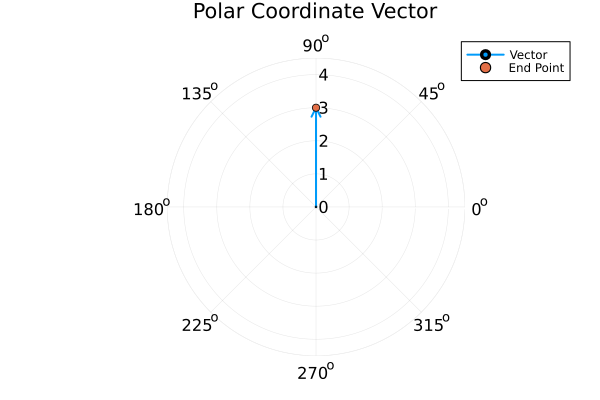

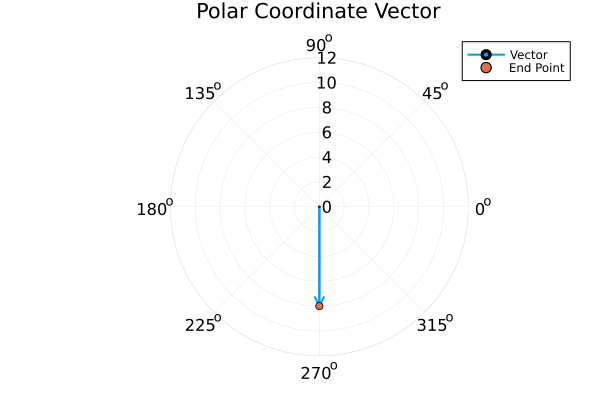

In [11]:
plotPolarVector(polA)
plotPolarVector(polB)
plotPolarVector(polA - polB)

In [12]:
function plotPolarWalk(polarCoords::Vector{PolarCoords})
    # Initialize the starting point
    startX, startY = 0.0, 0.0
    
    # Prepare arrays to hold the plot data
    xs, ys = [startX], [startY]
    
    # Iterate through the polar coordinates, converting each to Cartesian coordinates
    # and adding them to the plot data arrays
    for polarCoord in polarCoords
        cart = polarToCartesian(polarCoord)

        endX = startX + cart.x
        endY = startY + cart.y
        
        push!(xs, endX)
        push!(ys, endY)
        
        # Update the starting point for the next vector
        startX, startY = endX, endY
    end
    
    # Plot the sequence of vectors as a "random walk"
    p = plot(xs, ys, proj=:polar, m=1, label="Random Walk", lw=2, arrow=true,
             title="Polar Coordinate Random Walk", xlabel="Angle (radians)", ylabel="Radius")
    
    # Plot each vector's end point
    scatter!(xs, ys, label="End Points")
    
    display(p)
end

plotPolarWalk (generic function with 1 method)

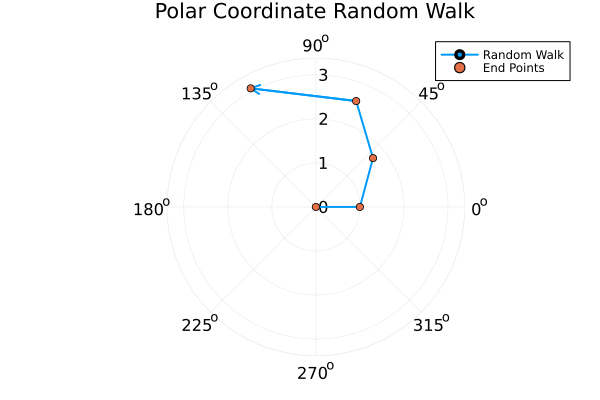

In [13]:
vectors = [PolarCoords(π/2, 1.0), PolarCoords(π/4, 1.0), PolarCoords(π/3, 1.0), PolarCoords(π/6, 1.0)]
plotPolarWalk(vectors)

In [14]:
# Assuming PolarCoords is already defined with fields angle (in radians) and radius

# Scalar multiplication for PolarCoords
function *(scalar::Real, polar::PolarCoords)::PolarCoords
    new_radius = scalar * polar.radius
    # The angle remains unchanged
    return PolarCoords(polar.angle, new_radius)
end

#needed to include the reversed type order for scalar multiplication!
function *(polar::PolarCoords, scalar::Real)::PolarCoords
    new_radius = scalar * polar.radius
    # The angle remains unchanged
    return PolarCoords(polar.angle, new_radius)
end

function /(polar::PolarCoords, scalar::Real)::PolarCoords
    return PolarCoords(polar.angle, polar.radius / scalar)
end

function dot(a::PolarCoords, b::PolarCoords)::Real
    carta = polarToCartesian(a)
    ax, ay = carta.x, carta.y
    cartb = polarToCartesian(b)
    bx, by = cartb.x, cartb.y
    return ax * bx + ay * by
end

import Base: ==, >, <, >=, <=

function ==(a::PolarCoords, b::PolarCoords)::Bool
    return a.radius == b.radius && a.angle == b.angle
end

function >(a::PolarCoords, b::PolarCoords)::Bool
    return a.radius > b.radius
end

function <(a::PolarCoords, b::PolarCoords)::Bool
    return a.radius < b.radius
end

function >=(a::PolarCoords, b::PolarCoords)::Bool
    return a.radius >= b.radius
end

function <=(a::PolarCoords, b::PolarCoords)::Bool
    return a.radius <= b.radius
end

# Phase shift for PolarCoords
function phaseShift(polar::PolarCoords, shift::Real)::PolarCoords
    new_angle = mod(polar.angle + shift, 2π)
    # The radius remains unchanged
    return PolarCoords(new_angle, polar.radius)
end

function phaseDiff(a::PolarCoords, b::PolarCoords)::Real
    return normalize(a.angle - b.angle)
end

phaseDiff (generic function with 1 method)

In [15]:
#this code works in Julia 1.8, but may be out of date relative to the latest version of Julia
for method in methodswith(CartesianCoords, ; supertypes=true)
    println(method)
end

*(scalar::Real, coords::CartesianCoords) in Main at /Users/z/Documents/GitHub/cadCAD.jl/notebooks/manual_testing.ipynb:11
*(coords::CartesianCoords, scalar::Real) in Main at /Users/z/Documents/GitHub/cadCAD.jl/notebooks/manual_testing.ipynb:16
+(a::CartesianCoords, b::CartesianCoords) in Main at /Users/z/Documents/GitHub/cadCAD.jl/notebooks/manual_testing.ipynb:3
-(a::CartesianCoords, b::CartesianCoords) in Main at /Users/z/Documents/GitHub/cadCAD.jl/notebooks/manual_testing.ipynb:7
/(coords::CartesianCoords, scalar::Real) in Main at /Users/z/Documents/GitHub/cadCAD.jl/notebooks/manual_testing.ipynb:20
<(a::CartesianCoords, b::CartesianCoords) in Main at /Users/z/Documents/GitHub/cadCAD.jl/notebooks/manual_testing.ipynb:40
<=(a::CartesianCoords, b::CartesianCoords) in Main at /Users/z/Documents/GitHub/cadCAD.jl/notebooks/manual_testing.ipynb:48
==(a::CartesianCoords, b::CartesianCoords) in Main at /Users/z/Documents/GitHub/cadCAD.jl/notebooks/manual_testing.ipynb:28
>(a::CartesianCoord

In [16]:
for method in methodswith(PolarCoords, ; supertypes=true)
    println(method)
end

*(scalar::Real, polar::PolarCoords) in Main at /Users/z/Documents/GitHub/cadCAD.jl/notebooks/manual_testing.ipynb:4
*(polar::PolarCoords, scalar::Real) in Main at /Users/z/Documents/GitHub/cadCAD.jl/notebooks/manual_testing.ipynb:11
+(a::PolarCoords, b::PolarCoords) in Main at /Users/z/Documents/GitHub/cadCAD.jl/notebooks/manual_testing.ipynb:1
-(a::PolarCoords) in Main at /Users/z/Documents/GitHub/cadCAD.jl/notebooks/manual_testing.ipynb:18
-(a::PolarCoords, b::PolarCoords) in Main at /Users/z/Documents/GitHub/cadCAD.jl/notebooks/manual_testing.ipynb:23
/(polar::PolarCoords, scalar::Real) in Main at /Users/z/Documents/GitHub/cadCAD.jl/notebooks/manual_testing.ipynb:17
<(a::PolarCoords, b::PolarCoords) in Main at /Users/z/Documents/GitHub/cadCAD.jl/notebooks/manual_testing.ipynb:39
<=(a::PolarCoords, b::PolarCoords) in Main at /Users/z/Documents/GitHub/cadCAD.jl/notebooks/manual_testing.ipynb:47
==(a::PolarCoords, b::PolarCoords) in Main at /Users/z/Documents/GitHub/cadCAD.jl/notebooks

In [17]:
using Test

In [18]:
@testset "CartesianCoords Operations" begin
    # Test addition
    a = CartesianCoords(1.0, 2.0)
    b = CartesianCoords(3.0, 4.0)
    @test a + b == CartesianCoords(4.0, 6.0)

    # Test subtraction
    @test a - b == CartesianCoords(-2.0, -2.0)

    # Test scalar multiplication
    @test 2 * a == CartesianCoords(2.0, 4.0)

    # Test scalar division
    @test a / 2 == CartesianCoords(0.5, 1.0)

    # Test dot product
    @test dot(a, b) == 11.0

    # Test magnitude
    @test magnitude(a) ≈ sqrt(5)

    # Test equality and inequalities
    c = CartesianCoords(1.0, 2.0)
    @test a == c
    @test b > a
    @test a < b
    @test b >= a
    @test a <= b
end

Test Summary:              | Pass  Total  Time
CartesianCoords Operations |   11     11  0.3s


Test.DefaultTestSet("CartesianCoords Operations", Any[], 11, false, false, true, 1.707974466551561e9, 1.707974466859905e9)

In [19]:
@testset "PolarCoords Operations" begin
    # Test addition
    p1 = PolarCoords(π/4, sqrt(2))
    p2 = PolarCoords(π/4, sqrt(2))
    result = p1 + p2
    @test result.radius ≈ 2*sqrt(2) atol=1e-5
    @test result.angle ≈ π/4 atol=1e-5

    polA = PolarCoords(3π/2, 5.0)
    polB = PolarCoords(π/2, 3.0)

    res = polA - polB
    # Test subtraction (specific cases may vary based on implementation)
    @test res.radius ≈ 8.0 atol=1e-5
    @test res.angle ≈ 4.71238898038469 atol=1e-5

    # Test scalar multiplication
    @test (2 * p1).radius ≈ 2*sqrt(2) atol=1e-5

    # Test scalar division
    @test (p1 / 2).radius ≈ sqrt(2)/2 atol=1e-5

    # Test dot product (specific cases may vary based on implementation)
    @test dot(p1, p2) ≈ 2.0 atol=1e-5

    # Test equality and inequalities
    p3 = PolarCoords(π/4, sqrt(2))
    @test p1 == p3
    @test p2 > p1 / 2
    @test p1 < p2 * 2
    @test p2 >= p1
    @test p1 <= p2
end

Test Summary:          | Pass  Total  Time
PolarCoords Operations |   12     12  0.1s


Test.DefaultTestSet("PolarCoords Operations", Any[], 12, false, false, true, 1.707974467263177e9, 1.707974467322078e9)

In [21]:
function generate_random_angle()
    return 2π * rand()
end

function generate_random_gain()
    return .5+rand()
end

function rescale(polar::PolarCoords)::PolarCoords
    rng = generate_random_gain()
    return rng * polar
end

function spin(polar::PolarCoords)::PolarCoords
    rng = generate_random_angle()
    return phaseShift(polar, rng)
end


spin (generic function with 1 method)

In [22]:
function >(f::Function, g::Function)
    return x -> g(f(x))
end

> (generic function with 6 methods)

In [23]:
dynamics = (cartesianToPolar > spin) > polarToCartesian

#17 (generic function with 1 method)

In [24]:
count = 10
traj = Vector{CartesianCoords}()
push!(traj, CartesianCoords(1.0, 1.0))


1-element Vector{CartesianCoords}:
 CartesianCoords(1.0, 1.0)

In [25]:
for i in 1:count
    new_point = dynamics(traj[i])
    push!(traj, new_point)
end

In [26]:
traj

11-element Vector{CartesianCoords}:
 CartesianCoords(1.0, 1.0)
 CartesianCoords(1.2241641851053502, 0.7081116069556791)
 CartesianCoords(1.326098151593035, 0.49138955253600636)
 CartesianCoords(-0.6200924988635986, 1.2710174242916965)
 CartesianCoords(0.277619267249127, -1.3866966295668488)
 CartesianCoords(1.0875431009474363, 0.9040188070950927)
 CartesianCoords(0.7076942302684824, -1.2244055196072503)
 CartesianCoords(0.30304228897906377, -1.3813635911990478)
 CartesianCoords(0.5334673014138408, -1.3097376219389265)
 CartesianCoords(0.7619518148164529, 1.191398099670263)
 CartesianCoords(0.6151372514714453, 1.2734230097858905)

In [32]:
end_point = cumsum(traj)[end]

CartesianCoords(7.216625092980634, 1.5371551380225548)

In [27]:
polar_traj = [cartesianToPolar(point) for point in traj]

11-element Vector{PolarCoords}:
 PolarCoords(0.7853981633974483, 1.4142135623730951)
 PolarCoords(0.5244194068994696, 1.4142135623730951)
 PolarCoords(0.35486617843413176, 1.4142135623730954)
 PolarCoords(2.024693711935864, 1.4142135623730951)
 PolarCoords(4.909978644628135, 1.4142135623730951)
 PolarCoords(0.693506748717982, 1.4142135623730951)
 PolarCoords(5.236467472600497, 1.4142135623730951)
 PolarCoords(4.928346963882783, 1.4142135623730951)
 PolarCoords(5.099179890607102, 1.4142135623730951)
 PolarCoords(1.0018065148903723, 1.4142135623730951)
 PolarCoords(1.1207938971508216, 1.4142135623730951)

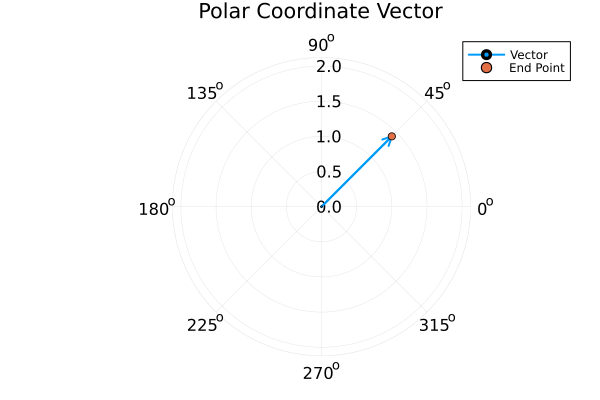

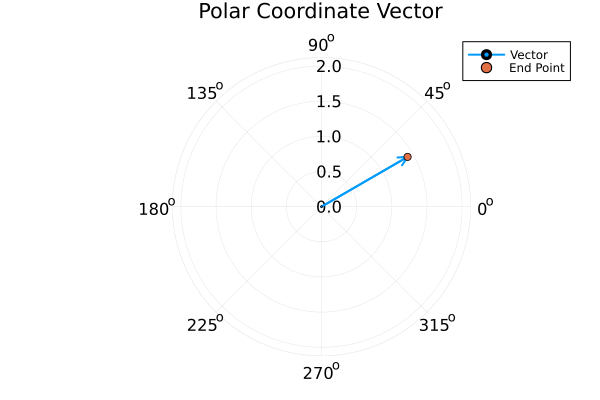

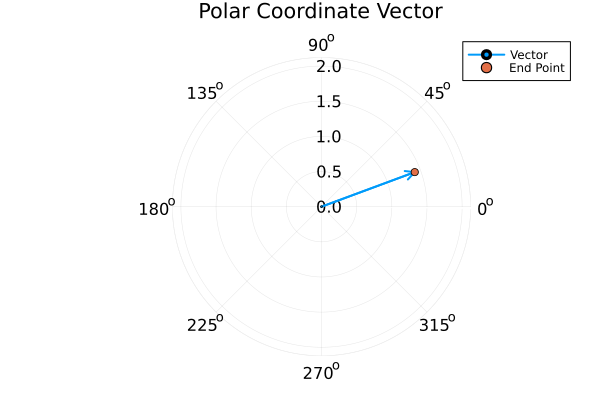

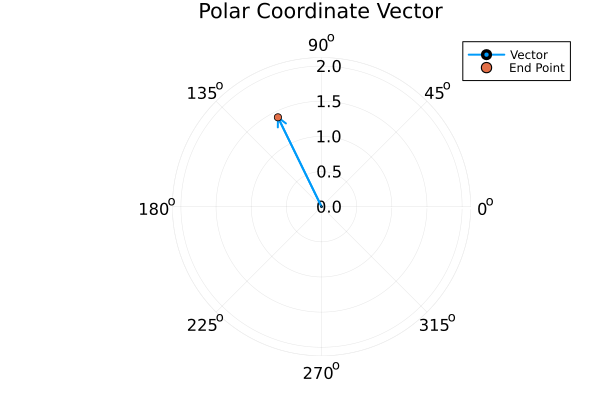

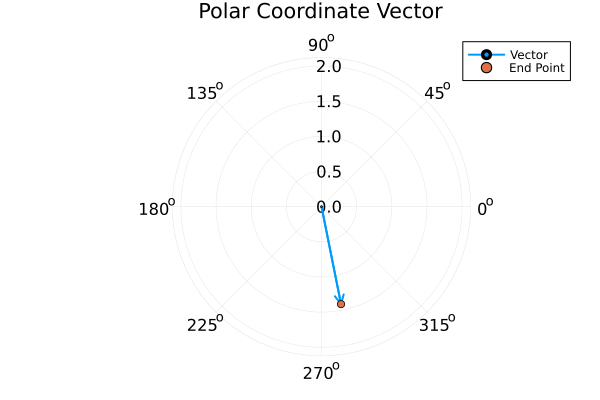

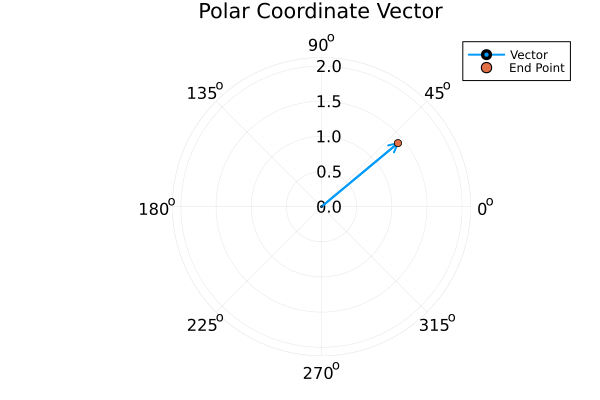

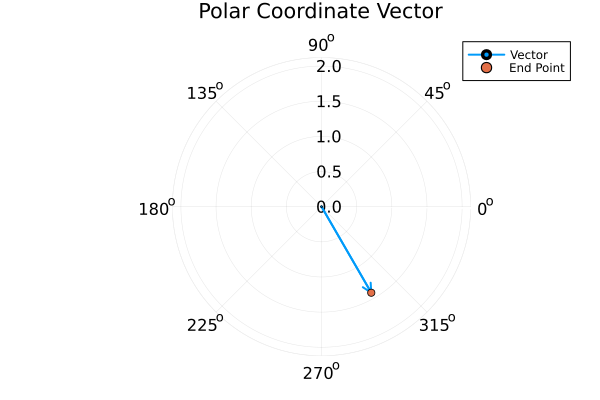

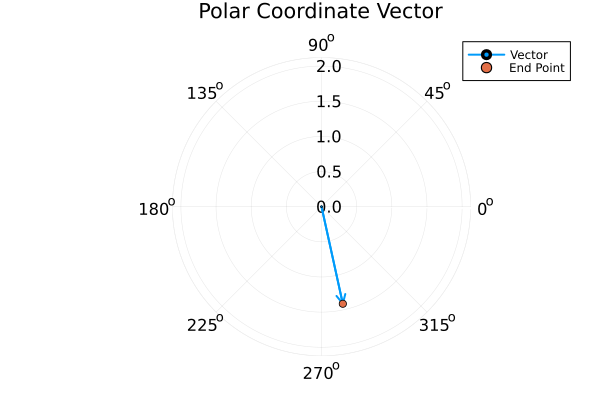

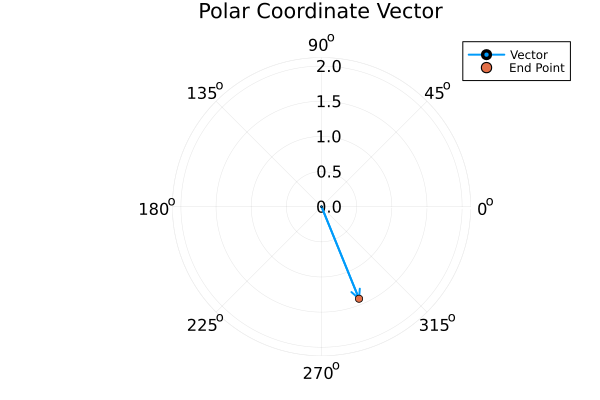

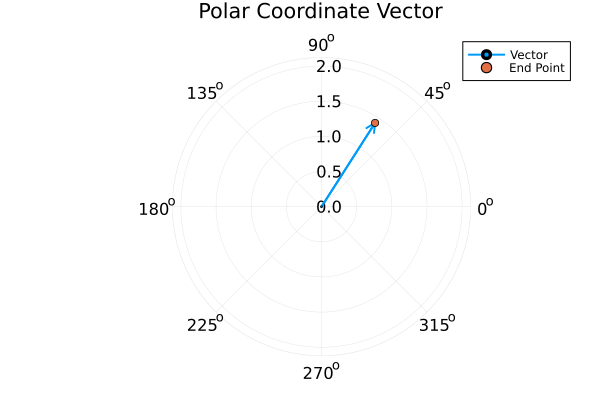

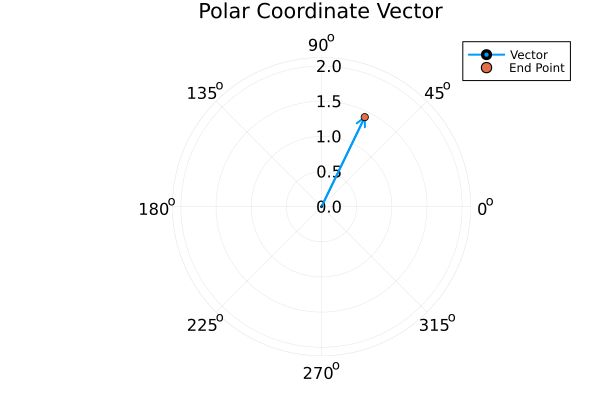

In [34]:
for point in polar_traj
    polar_plot = plotPolarVector(point)
end

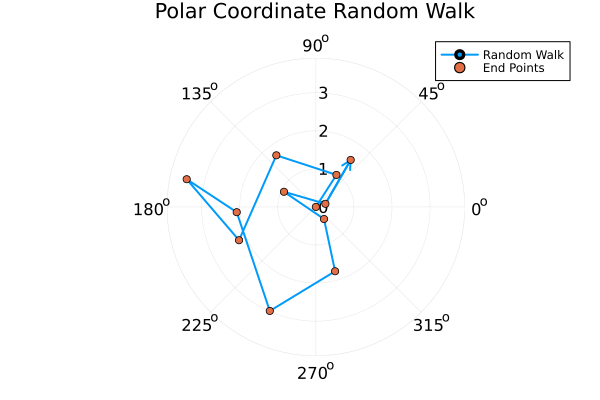

In [28]:
plotPolarWalk(polar_traj)